In [4]:
###############################################
## LOAD MODULES                              ##
###############################################
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

###############################################
## FUNCTIONS                                 ##
###############################################

#Define Filter Function
def filterEEG(EEG):
    #Bandpass
    w = [x / 100 for x in [0.1, 30]]
    b, a = signal.butter(4, w, 'band')
    
    #Notch
    b_notch, a_notch = signal.iirnotch(60, 30, 500)

    #Process
    if EEG.ndim == 2: #If it's two-dimensional, iterate through trials
        tempFilteredEEG = [signal.filtfilt(b, a, EEG[trial,:]) for trial in range(len(EEG))] #Bandpass filter
        filteredEEG = [signal.filtfilt(b_notch, a_notch, tempFilteredEEG[trial]) for trial in range(len(EEG))] #Notch filter
    else: #Else just process the single tria provided
        tempFilteredEEG = signal.filtfilt(b, a, EEG) #Bandpass filter
        filteredEEG = signal.filtfilt(b_notch, a_notch, tempFilteredEEG) #Notch filter
    
    return filteredEEG

#Define Baseline Function
def baselineCorrect(EEG):
    #Baseline
    baselineRange = [0, 20]

    #Process
    baselinedEEG = [(EEG[trial] - (np.mean(EEG[trial][baselineRange[0]:baselineRange[1]]))) for trial in range(len(EEG))]

    return baselinedEEG

###############################################
## LOAD AND PROCESS DATA                     ##
###############################################

#Load EEG Data (Participant, Condition, Trial, Electrode, Time1, ...)
EEGData = np.genfromtxt('../data/Reinforcement Learning/Full Datasets/ganTrialElectrodeERP_p500_e1_len100.csv', delimiter=',', skip_header=1)[:,1:] #Removes Participant Column
EEGData = np.delete(EEGData, 1, 1) #Delete Unused Column (Trial)

#Split into conditions
lossEEGData = EEGData[np.r_[EEGData[:,0]==1],2:] #TODO: For now, remove the electrode column but we need to keep it
winEEGData = EEGData[np.r_[EEGData[:,0]==0],2:] #TODO: For now, remove the electrode column but we need to keep it

#Load and Process Synthetic Data (Condition, Electrode, Time0, ...)
synData0 = np.genfromtxt('../generated_samples/Reinforcement Learning/Full Datasets/aegan_ep2000_p500_e1_full_c0.csv', delimiter=',', skip_header=1)
synData1 = np.genfromtxt('../generated_samples/Reinforcement Learning/Full Datasets/aegan_ep2000_p500_e1_full_c1.csv', delimiter=',', skip_header=1)
synData = np.vstack((synData0, synData1))
synData = np.delete(synData, 1,1) #TODO: For now, remove the electrode column but we need to keep it

#Process synthetic data
tempSynData = filterEEG(synData[:,1:])
dtempSynData = baselineCorrect(tempSynData)

#Create and populate new array for processed synthetic data
processedSynData = np.zeros((len(tempSynData),101))
processedSynData[:,0] = synData[:,0]
processedSynData[:,1:] = np.array(tempSynData)

#Split into conditions
lossSynData = processedSynData[np.r_[processedSynData[:,0]==1],1:]
winSynData = processedSynData[np.r_[processedSynData[:,0]==0],1:]

#Average data
avgLossSynData = np.mean(lossSynData, axis=0)
avgWinSynData = np.mean(winSynData, axis=0)

#Scale synthetic data 
EEGDataScale = np.max(np.mean(lossEEGData, axis=0))-np.min(np.mean(lossEEGData, axis=0))
EEGDataOffset = np.min(np.mean(lossEEGData, axis=0))
synDataScale = np.max(avgLossSynData)-np.min(avgLossSynData)
synDataOffset = np.min(avgLossSynData)

avgLossSynData = (((avgLossSynData-synDataOffset)/synDataScale)*EEGDataScale)+EEGDataOffset
avgWinSynData = (((avgWinSynData-synDataOffset)/synDataScale)*EEGDataScale)+EEGDataOffset

print('Data loading complete!')

Data loading complete!


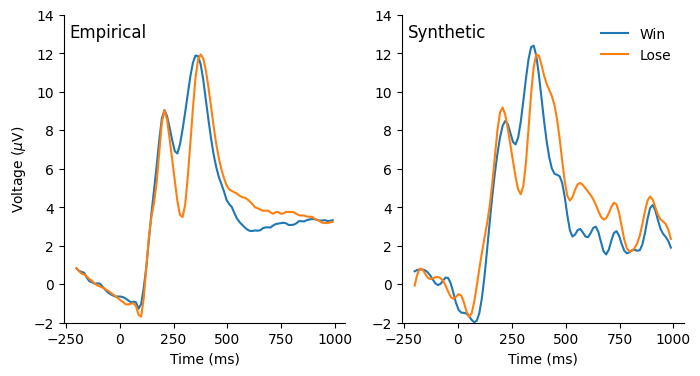

In [58]:
###############################################
## PLOT ERPS                                 ##
###############################################

#Determine x axis
time = np.arange(-200, 1000, 12)

#Plot empirical ERPs
ax1 = plt.subplot(1,2,1)
plt.plot(time, np.mean(winEEGData, axis=0))
plt.plot(time, np.mean(lossEEGData, axis=0))
plt.ylabel(r'Voltage ($\mu$V)')
plt.xlabel('Time (ms)')
plt.title('Empirical', loc = 'left', x = .02, y=.9)
plt.ylim((-2,14))
ax1.spines.right.set_visible(False)
ax1.spines.top.set_visible(False)

#Plot synthetic ERPs
ax2 = plt.subplot(1,2,2)
plt.plot(time, avgWinSynData)
plt.plot(time, avgLossSynData)
plt.xlabel('Time (ms)')
plt.title('Synthetic', loc = 'left', x = .02, y=.9)
plt.ylim((-2,14))
ax2.spines.right.set_visible(False)
ax2.spines.top.set_visible(False)
ax2.legend(['Win', 'Lose'],frameon=False)

#Save plot
fig = plt.gcf()
fig.set_size_inches(8, 4)
fig.savefig('Figure 3.png', dpi=600)

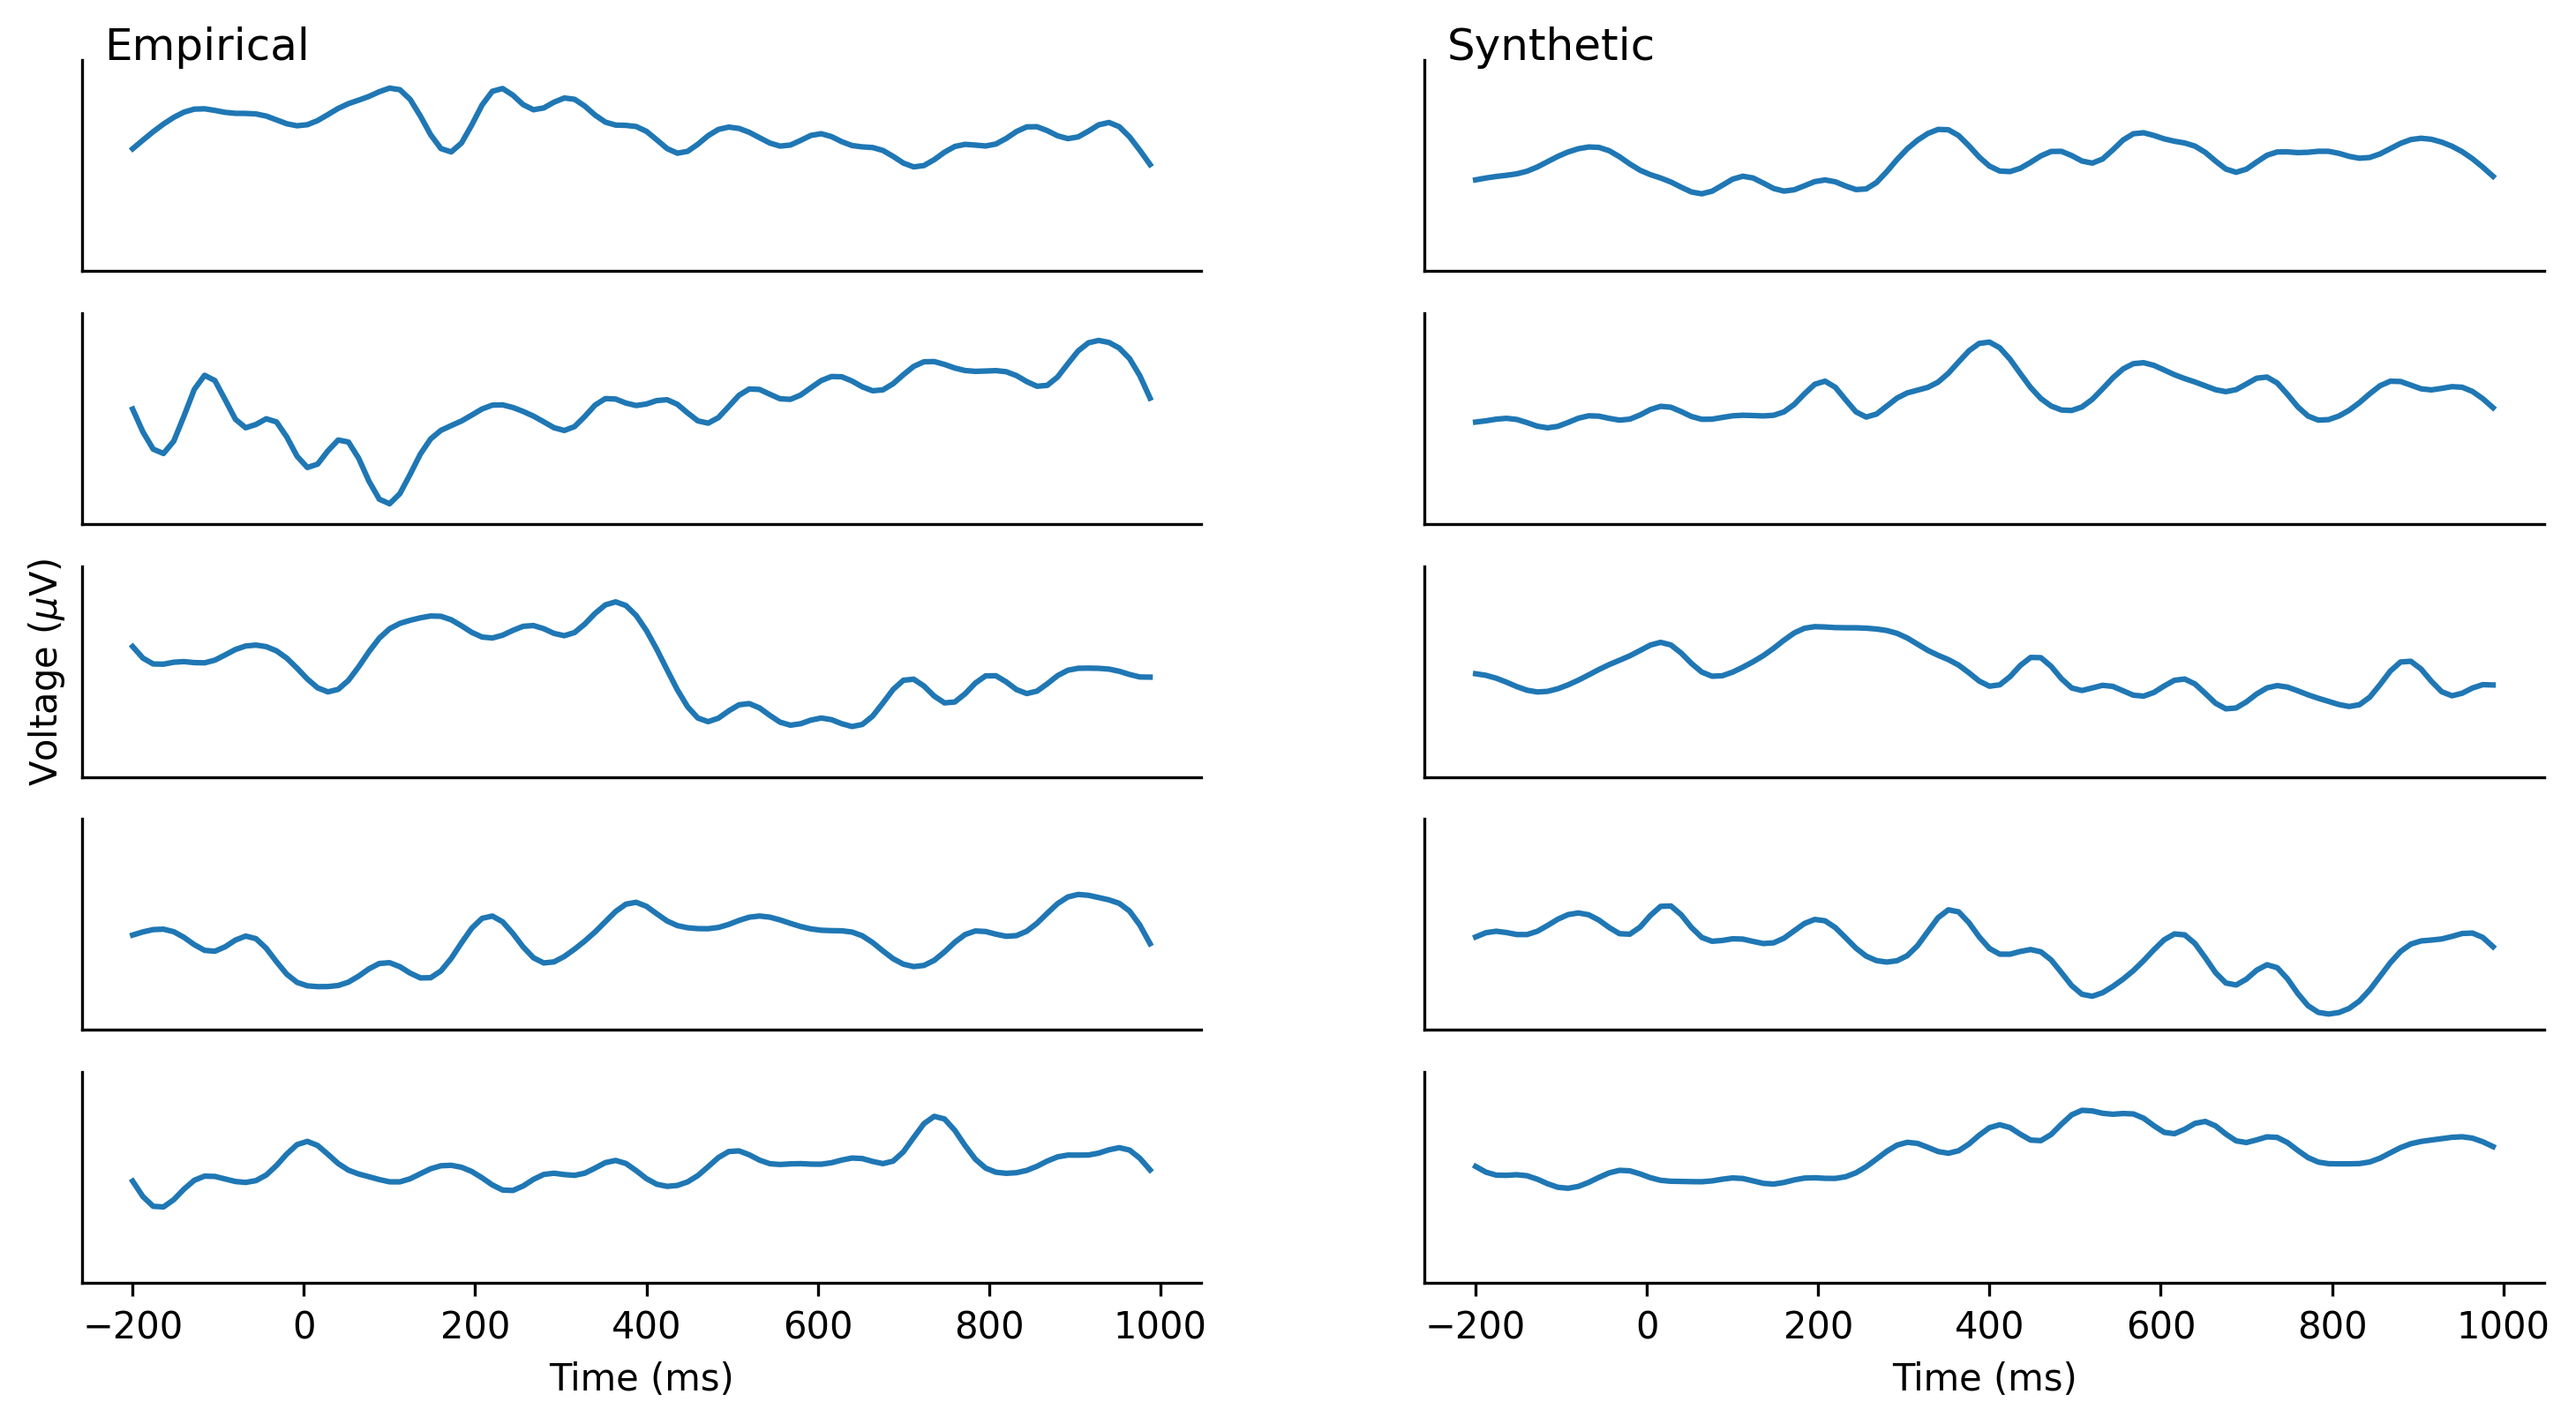

In [62]:
###############################################
## PLOT TRIAL DATA                           ##
###############################################

#Determine x axis
time = np.arange(-200, 1000, 12)

#Setup plot and variables
plt.figure(figsize=(12, 6), dpi=300)
x=1

#Iterate to produce 5 plots for each empirical and synthetic
for counter in range(5):
    
    #Plot empirical trial
    ax1 = plt.subplot(5,2,x)
    plt.plot(time, filterEEG(winEEGData[counter*20,:]))
    
    #Constrain labels and titles
    if counter == 2:
        plt.ylabel(r'Voltage ($\mu$V)')
    if counter == 0:
        plt.title('Empirical', loc = 'left', x = .02, y=.9)
        
    #Format specific sublots
    if counter != 4:
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
    else:
        plt.xlabel('Time (ms)')
        
    #Format plot
    plt.ylim((-45,45))
    ax1.spines.right.set_visible(False)
    ax1.spines.top.set_visible(False)
    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelleft=False) # labels along the bottom edge are off
    
    #Plot synthetic trial
    ax1 = plt.subplot(5,2,x+1)
    plt.plot(time, winSynData[counter*20,:])
    
    #Constrain labels and titles
    if counter == 0:
        plt.title('Synthetic', loc = 'left', x = .02, y=.9)

    #Format specific sublots
    if counter != 4:
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
    else:
        plt.xlabel('Time (ms)')
        
    #Format plot
    plt.ylim((-.3,.3))
    ax1.spines.right.set_visible(False)
    ax1.spines.top.set_visible(False)
    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelleft=False) # labels along the bottom edge are off
    
    #Increase count
    x+=2
    
#Save plot
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('Figure 2.png', dpi=600)

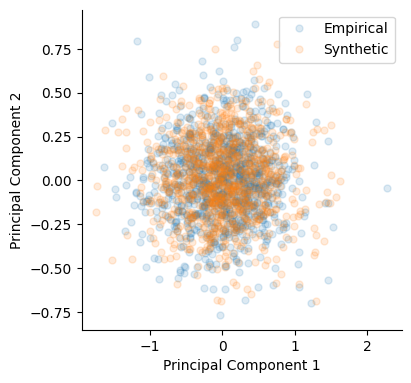

In [60]:
###############################################
## PLOT PCA                                  ##
###############################################

#Load PCA data
pcaData = np.genfromtxt('pca_results.csv', delimiter=',', skip_header=1)

#Plot data
ax = plt.subplot(1,1,1)
plt.plot(pcaData[:,0],pcaData[:,1],'o',alpha=0.15, markersize=5)
plt.plot(pcaData[:,2],pcaData[:,3],'o',alpha=0.15, markersize=5)
plt.ylabel('Principal Component 2')
plt.xlabel('Principal Component 1')
plt.rcParams.update({'font.size': 10})
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.legend(['Empirical', 'Synthetic'])
plt.tight_layout()
plt.subplots_adjust(left=0.2, right = 1, bottom = .2, top = 1)

#Save plot
fig = plt.gcf()
fig.set_size_inches(4, 4)
fig.savefig('Figure 4.png', dpi=300)